In [5]:
import pandas as pd

df = pd.read_csv('comments.csv', lineterminator='\n')

In [6]:
import re

documents = df['text'].dropna().tolist()
# Remove duplicates
documents = list(dict.fromkeys(documents))

# Remove non-ASCII characters 
documents = [string.encode('ascii','ignore').decode() for string in documents]   

# Remove '\n'
documents = [string.replace('\n',' ') for string in documents]

# Remove punctuations
punctuations = '''!()-[]{};:'",<>./?@#$%^&*_~'''
for i in range(len(documents)):  
    for character in documents[i]:
        if character in punctuations:  
            documents[i] = documents[i].replace(character, "")
            
# Remove repeated patterns (e.g. I WANT THIS I WANT THIS I WANT THIS)
documents = [re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', string, flags=re.I) for string in documents]

In [7]:
len(documents)

162850

Some of the code was modified from "Topic Modeling and Latent Dirichlet Allocation (LDA) in Python" by Susan Li
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [8]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem.porter import *
import numpy as np
#import nltk
#nltk.download('wordnet')

In [9]:
#def lemmatize_stemming(text):
#    stemmer = SnowballStemmer('english')
#    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


# Tokenize; gensim.preprocess; remove stopwords; remove common words (e.g. wtf); 
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS: #and len(token) > 1:
            result.append(token) # lemmatize_stemming(token)
        
        common_words = set('wow wtf shit fuck fucking crap lol plz yo xd hey omg im ive oh'.split(' '))
        result = [string for string in result if string not in common_words] 
        
    return result

In [182]:
processed_docs = list(map(preprocess, documents))

In [184]:
# Compute bigrams & trigrams
from gensim.models import Phrases

bigram_model = Phrases(processed_docs) #min_count=50
bigrams = list(bigram_model[processed_docs])
trigram_model = Phrases(bigrams)
trigrams = list(trigram_model[bigrams])

In [185]:
for i in range(len(processed_docs)):
    for token in bigrams[i]:
        if '_' in token:
            # Token is a bigram
            processed_docs[i].append(token)
    for token in trigrams[i]:
        if '_' in token:
            # Token is a trigram
            processed_docs[i].append(token)

In [187]:
# A dictionary containing frequency counts
from gensim.corpora import Dictionary

dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=50, no_above=0.5) #keep_n=100000

In [188]:
# Bag-of-words vector representation
corpus = [dictionary.doc2bow(d) for d in processed_docs] 
# corpus is the collection of our pre-processed comments

Some of the code is modified from "Topic Modeling with Gensim (Python)"
by Selva Prabhakaran https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#13viewthetopicsinldamodel

In [189]:
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start):
    # Compute coherence scores for various number of topics to choose the optimal num_topics
    # Return a list of models with different number of topics and a list of corresponding scores
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit):
        model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [190]:
model_list, coherence_values = compute_coherence_values(dictionary, corpus, texts=processed_docs, start=2, limit=21)

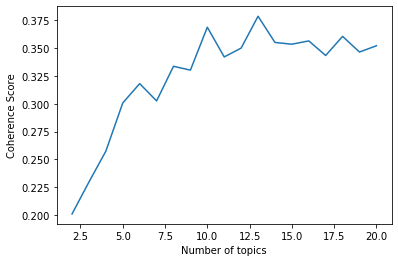

In [191]:
import matplotlib.pyplot as plt

n_topics = range(2,21)
plt.plot(n_topics, coherence_values)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score')
plt.show()

In [192]:
# Optimal model: num_topics = 13
model = model_list[11]
model.save('LDAModel')

In [194]:
%matplotlib inline
pyLDAvis.enable_notebook()
v = pyLDAvis.gensim.prepare(model, corpus, dictionary)
v

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.047639  0.182624       1        1  12.552160
12     0.099067  0.169013       2        1  10.189656
8      0.204038 -0.056128       3        1   9.940212
1      0.173816 -0.015529       4        1   8.066287
6     -0.037838  0.181378       5        1   7.786451
0     -0.181381  0.040808       6        1   7.073967
7      0.064993 -0.123567       7        1   6.974194
5     -0.023958 -0.122114       8        1   6.894079
4     -0.074858  0.211793       9        1   6.842404
2     -0.164989 -0.051309      10        1   6.478956
3      0.214379 -0.189551      11        1   6.448895
9     -0.058635 -0.017398      12        1   6.082776
11    -0.262273 -0.210019      13        1   4.669963, topic_info=           Term          Freq         Total Category  logprob  loglift
124        like  17140.000000  17140.000000  Default  30.0000  30.0000
125       looks  11155.000000  11155.000000  Default  29.0000  29.0000
489          cd   4992.000000   4992.000000  Default  28.0000  28.0000
226        dont   5802.000000   5802.000000  Default  27.0000  27.0000
117        wait   5365.000000   5365.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
551       whats   1246.201416   1415.143188  Topic13  -3.4191   2.9369
64         real   1521.327515   2143.135498  Topic13  -3.2196   2.7213
571       scene    383.005524    464.063477  Topic13  -4.5989   2.8720
2003      genre    470.054657    893.336548  Topic13  -4.3941   2.4219
112   cyberpunk    722.057190   9129.838867  Topic13  -3.9649   0.5268

[615 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
601       2  0.775345        able
601       4  0.223205        able
1515      6  0.999098  absolutely
394       5  0.237108      actual
394       8  0.688331      actual
...     ...       ...         ...
524       2  0.447018       youre
524       4  0.082852       youre
524       9  0.468213       youre
444       7  0.764582     youtube
444      10  0.232773     youtube

[855 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 13, 9, 2, 7, 1, 8, 6, 5, 3, 4, 10, 12])

In [195]:
# Find the corresponding topic of each document according to the percentage contribution
def topic_of_doc(ldamodel=model, corpus=corpus, texts=documents):
    topics_df = pd.DataFrame()
    # Get main topic for each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # list of tuples containing topic number and prob, sorted by the latter
        # Get the dominant topic, percentage contribution (prob) and keywords for each document
        for j, (topic_num, prob) in enumerate(row):
            if j == 0:  # dominant topic (the most likely topic)
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prob in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prob,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Prob', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)

# output
topic_of_doc_df = topic_of_doc().reset_index()
topic_of_doc_df.columns = ['No.', 'Dominant Topic', 'Prob', 'Keywords', 'Comment']

In [196]:
topic_of_doc_df.head(10)

,No.,Dominant Topic,Prob,Keywords,Comment
0,0,7.0,0.4513,"song, music, trailer, like, end, read, years_a...",This game are mix with the 80s and the future ...
1,1,6.0,0.6923,"game, people, coming, didnt, trailer, time, lo...",2902 Remember these guys are really shit
2,2,10.0,0.4156,"game, wait, good, witcher, games, best, going,...",I would replay this game 100x
3,3,10.0,0.4904,"game, wait, good, witcher, games, best, going,...",So you could complete the game without killing...
4,4,7.0,0.4154,"song, music, trailer, like, end, read, years_a...",After listening to 80 hours of aggressive musi...
5,5,7.0,0.3800,"song, music, trailer, like, end, read, years_a...",Next level by CDPR they even got Triss Merigol...
6,6,8.0,0.5384,"like, deus_ex, look, great, ex, deus, game, gh...",Nothing special
7,7,7.0,0.3593,"song, music, trailer, like, end, read, years_a...",you can never go wrong with rocky
8,8,10.0,0.6154,"game, wait, good, witcher, games, best, going,...",Its going to be one the best games of our century
9,9,2.0,0.3590,"years, release, release_date, trailer, cyberpu...",Why tf they r not releasing it in lockdown


In [197]:
topic_of_doc_df.to_pickle('topic_of_comment.pkl')

In [3]:
#topic_of_doc_df = pd.read_pickle('topic_of_comment.pkl')

In [5]:
# Find the most representative document for each topic 
representative_df = pd.DataFrame()

groupby_object = topic_of_doc_df.groupby('Dominant Topic')

for i, group in groupby_object:
    representative_df = pd.concat([representative_df, group.sort_values(['Prob'], ascending=[0]).head(10)], axis=0)

# output   
representative_df.reset_index(drop=True, inplace=True)
#representative_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [6]:
representative_df.to_pickle('representative_comments.pkl')

### Comments for topic #9 contain some non-English words (ASCII letters, but not English).
### Comments for  topic #10 contain some repeated texts (in different formats, so they were not preprocessed).
### To gain a better understanding of the topics, a new representative dataframe was created with top 20 comments for each topic.

In [14]:
representative_df_2 = pd.DataFrame()

groupby_object = topic_of_doc_df.groupby('Dominant Topic')

for i, group in groupby_object:
    representative_df_2 = pd.concat([representative_df_2, group.sort_values(['Prob'], ascending=[0]).head(20)], axis=0)

# output   
representative_df_2.reset_index(drop=True, inplace=True)
#representative_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [15]:
representative_df_2.to_pickle('representative_comments_2.pkl')